_Version log: Using L2 as well as L1_

In [1]:
import sys
from sklearn.linear_model import Lasso #I'm using scikit insted of svxpy to solve.
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches
import scipy.ndimage as spimg
from scipy import optimize as spopt, fft as spfft
from PIL import Image #I prefer Pillow to imageio
plt.rcParams.update({'font.size':16})
np.set_printoptions(threshold=sys.maxsize)

To turn a sparce signal $X$ into the full image $Y$. The L1 norm of,
\begin{equation}
    \mathcal{F} (Y),
\end{equation}
needs to be minimised while also minimising the L2 norm of,
\begin{equation}
    C \times \mathcal{F}^{-1} (I) \times \mathcal{F} (Y) - X,
\end{equation}
where $\mathcal{F}( )$ is the DCT, $I$ is an identerty matrix and $C$ is a cropping transformation matrix such that,
\begin{equation}
    C \times Y = X.
\end{equation}
The weighting between the first two equation can be changed using the regularisation coeffient, $\alpha$. Altogether, the function that needs to be minimised looks like,
\begin{equation}
    ||C \times \mathcal{F}^{-1} (I) \times \mathcal{F} (Y) - X||_{2} + \alpha ||\mathcal{F} (Y)||_{1},
\end{equation}
which can be re-writtern in terms of the measurement matrix $M$ and $\mathcal{F} (Y) = Y'$ as,
\begin{equation}
    ||M \times Y' - X||_{2} + \alpha ||Y'||_{1}.
\end{equation}

In [2]:
def open_compressed_dataset(file_name, file_type, compression):
    if file_type == ".csv":
        img = np.loadtxt("data\\" +file_name +file_type, delimiter=",")
        array = spimg.zoom(img, compression) # scipy ndimage.zoom compresses (or interpolates) an image.
    else:
        raise ValueError("{0:} is not a regonised file type.".format(file_type))
    return array, img

def subsample_1d(array, subsampling_percentage = 0.5, subsampling_method = "random"):
    
    total_points = len(array)

    if subsampling_method == "random":
        reduced_points = round(total_points *subsampling_percentage)
        subsampled_points = np.random.choice(total_points, reduced_points, replace= False)

    if subsampling_method == "regular":
        reduced_points = round(total_points *subsampling_percentage)
        subsampled_points = np.round(np.linspace(0, total_points -1, reduced_points)).astype(int)
     
    subsampled_points = np.sort(subsampled_points) #Not nessisary but makes it easier to look at.
    signal = np.full(total_points, np.nan)
    signal[subsampled_points] = array[subsampled_points]
    signal_sparce = array[subsampled_points]

    return signal, signal_sparce, subsampled_points



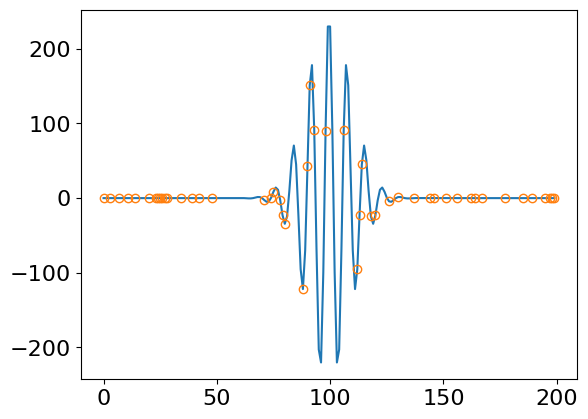

In [3]:
file_name = "1d_mock_interferogram"
file_type = ".csv"
compression = 0.2 #fraction of the dataset to keep
subsample_percentage = 0.25 #fraction of the dataset to subsample
subsampling_method= "random" #"random" "regular"

# original image
target, img = open_compressed_dataset(file_name, file_type, compression)
#target = target[200:801] #crop it
total_points = len(target)

signal, signal_sparce, random_points = subsample_1d(target, subsampling_percentage= subsample_percentage, subsampling_method= subsampling_method)


plt.plot(target)
plt.plot(signal, marker= "o", markerfacecolor= "None", linestyle= "None")

plt.show()

In [8]:
random_points

array([  0,   3,   7,  11,  14,  20,  23,  24,  25,  26,  27,  28,  34,
        39,  42,  48,  71,  74,  75,  78,  79,  80,  88,  90,  91,  93,
        98, 106, 112, 113, 114, 118, 120, 126, 130, 137, 144, 146, 151,
       156, 162, 164, 167, 177, 185, 189, 195, 197, 198, 199])

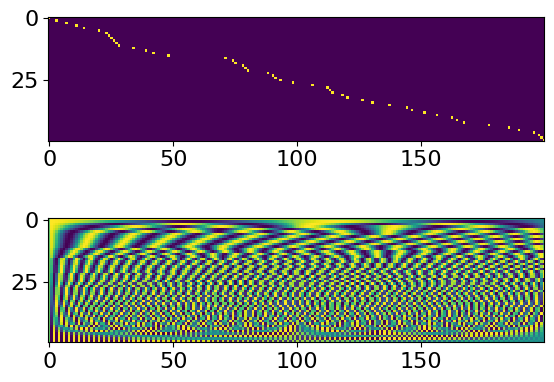

In [4]:
cropping_matrix = np.identity(total_points, dtype= np.float16)
cropping_matrix = cropping_matrix[random_points] #cropping matrix operator

dct_matrix = spfft.idct(np.identity(total_points), axis= 0)
measurement_matrix = np.matmul(cropping_matrix, dct_matrix)

fig, axs = plt.subplots(2,1)

axs[0].imshow(cropping_matrix, interpolation= "nearest")
axs[1].imshow(measurement_matrix, interpolation= "nearest")

plt.show()

In [5]:
regularization_coeffient = 1e-2 # DECREASE FOR COMPLEX IMAGES (up to 1e-7 (floating point error?)) INCREASE FOR SIMPLE IMAGES (up to 1e-2)

lasso = Lasso(alpha=regularization_coeffient)
lasso.fit(measurement_matrix, signal_sparce)
result_comp_L1 = lasso.coef_

print(result_comp_L1.shape)
print(total_points)

(200,)
200


42.597198827420016


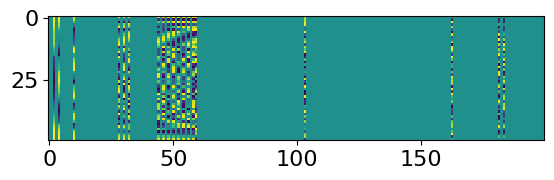

C:\Users\syf83691\AppData\Local\Temp\ipykernel_1624\1938124341.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  least_squares_result = np.linalg.lstsq(active_matrix, signal_sparce)


In [6]:
relative_activation_threshold = 1e-2 # WEAK COMPONENTS WILL NOT BE CONSIDERED FOR THE L2 SOLUTION
activation_threshold = relative_activation_threshold*np.nanmax(np.abs(result_comp_L1))

active_components = np.abs(result_comp_L1) >= activation_threshold
print(activation_threshold)

active_matrix = np.zeros_like(measurement_matrix)
active_matrix[:, active_components] = measurement_matrix[:, active_components]

plt.imshow(active_matrix, interpolation= "nearest")
plt.show()

result_comp_L2 = np.zeros_like(result_comp_L1)
least_squares_result = np.linalg.lstsq(active_matrix, signal_sparce)
result_comp_L2[active_components] = least_squares_result[0][active_components]

C:\Users\syf83691\AppData\Local\Temp\ipykernel_1624\895350927.py:3: RuntimeWarning: divide by zero encountered in divide
  result_L1_wavelengths= 1/ np.fft.rfftfreq(len(result_L1))
C:\Users\syf83691\AppData\Local\Temp\ipykernel_1624\895350927.py:6: RuntimeWarning: divide by zero encountered in divide
  target_wavelengths= 1/ np.fft.rfftfreq(len(target))
C:\Users\syf83691\AppData\Local\Temp\ipykernel_1624\895350927.py:9: RuntimeWarning: divide by zero encountered in divide
  result_L2_wavelengths= 1/ np.fft.rfftfreq(len(result_L2))


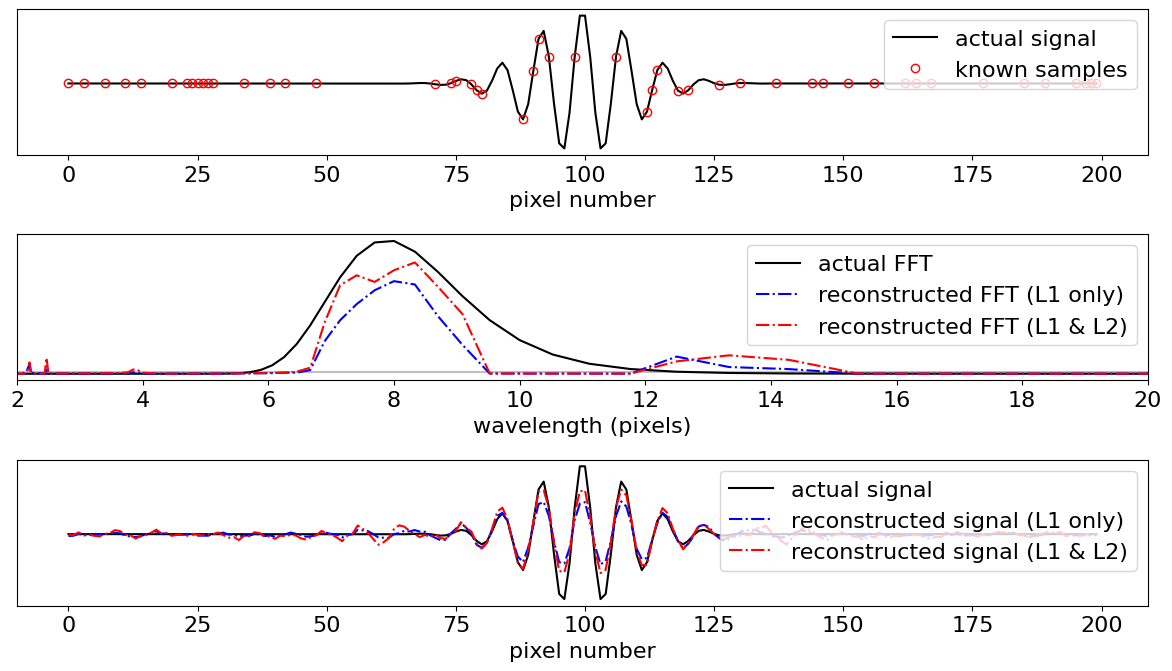

In [7]:
result_L1 = spfft.idct(result_comp_L1)
result_L1_FFT = np.abs(np.fft.rfft(result_L1))
result_L1_wavelengths= 1/ np.fft.rfftfreq(len(result_L1))
target_DCT = spfft.dct(target)
target_FFT = np.abs(np.fft.rfft(target))
target_wavelengths= 1/ np.fft.rfftfreq(len(target))
result_L2 = spfft.idct(result_comp_L2)
result_L2_FFT = np.abs(np.fft.rfft(result_L2))
result_L2_wavelengths= 1/ np.fft.rfftfreq(len(result_L2))

niquist = 0.5/1 # pixels^-1
k = niquist *np.arange(total_points) /total_points


plt.rcParams.update({'font.size':16})
fig, axs = plt.subplots(3,1, figsize= (12,7))

axs[0].plot(target, color= "k", label= "actual signal")
axs[0].plot(signal, marker= "o", markerfacecolor= "None", color= "red", linestyle= "None", label= "known samples")
axs[0].set(xlabel= "pixel number")
axs[1].hlines(activation_threshold, target_wavelengths.min(), 20, color= "silver")
axs[1].plot(target_wavelengths, target_FFT, color= "k", label= "actual FFT")
axs[1].plot(result_L1_wavelengths, result_L1_FFT, color= "blue", label= "reconstructed FFT (L1 only)", linestyle= "-.")
axs[1].plot(result_L2_wavelengths, result_L2_FFT, color= "red", label= "reconstructed FFT (L1 & L2)", linestyle= "-.")
axs[1].set_xlim(target_wavelengths.min(),20)
axs[1].set(xlabel= "wavelength (pixels)")
axs[2].plot(target, color= "k", label= "actual signal")
axs[2].plot(result_L1, color= "blue", label= "reconstructed signal (L1 only)", linestyle= "-.")
axs[2].plot(result_L2, color= "red", label= "reconstructed signal (L1 & L2)", linestyle= "-.")
axs[2].set(xlabel= "pixel number")

[ax.legend(loc= 'upper right') for ax in axs]
[ax.set(yticks= []) for ax in axs]

plt.tight_layout()
plt.show()